# Fake News Exploratory Data Analysis

Get subset of FakeNewCorpus data set.

In [37]:
import pandas as pd
import regex as re
from cleantext import clean
raw_data = pd.read_csv('https://raw.githubusercontent.com/several27/FakeNewsCorpus/master/news_sample.csv', dtype={"content": "string"})
raw_data.head()

,Unnamed: 0,id,domain,type,url,content,scraped_at,inserted_at,updated_at,title,authors,keywords,meta_keywords,meta_description,tags,summary
0,0,141,awm.com,unreliable,http://awm.com/church-congregation-brings-gift...,Sometimes the power of Christmas will make you...,2018-01-25 16:17:44.789555,2018-02-02 01:19:41.756632,2018-02-02 01:19:41.756664,Church Congregation Brings Gift to Waitresses ...,Ruth Harris,NaN,[''],NaN,NaN,NaN
1,1,256,beforeitsnews.com,fake,http://beforeitsnews.com/awakening-start-here/...,AWAKENING OF 12 STRANDS of DNA – “Reconnecting...,2018-01-25 16:17:44.789555,2018-02-02 01:19:41.756632,2018-02-02 01:19:41.756664,AWAKENING OF 12 STRANDS of DNA – “Reconnecting...,Zurich Times,NaN,[''],NaN,NaN,NaN
2,2,700,cnnnext.com,unreliable,http://www.cnnnext.com/video/18526/never-hike-...,Never Hike Alone: A Friday the 13th Fan Film U...,2018-01-25 16:17:44.789555,2018-02-02 01:19:41.756632,2018-02-02 01:19:41.756664,Never Hike Alone - A Friday the 13th Fan Film ...,NaN,NaN,[''],Never Hike Alone: A Friday the 13th Fan Film ...,NaN,NaN
3,3,768,awm.com,unreliable,http://awm.com/elusive-alien-of-the-sea-caught...,"When a rare shark was caught, scientists were ...",2018-01-25 16:17:44.789555,2018-02-02 01:19:41.756632,2018-02-02 01:19:41.756664,Elusive ‘Alien Of The Sea ‘ Caught By Scientis...,Alexander Smith,NaN,[''],NaN,NaN,NaN
4,4,791,bipartisanreport.com,clickbait,http://bipartisanreport.com/2018/01/21/trumps-...,Donald Trump has the unnerving ability to abil...,2018-01-25 16:17:44.789555,2018-02-02 01:19:41.756632,2018-02-02 01:19:41.756664,Trump’s Genius Poll Is Complete & The Results ...,Gloria Christie,NaN,[''],NaN,NaN,NaN


# Cleaning and preprocessing

Perform basic cleaning: remove urls, dates, numbers, emails.

In [38]:
data = raw_data.copy(deep = True)

In [39]:
pattern = re.compile(r"([\d]{1,2}[\/|\-][\d]{1,2}(?:[\/|\-][\d]{2,4})?|[\d]{2,4}[\/|\-][\d]{1,2}[\/|\-][\d]{1,2}|(?:january|february|march|april|may|june|july|august|september|october|november|december)[\s][\d]{1,2}[a-z][a-z](?:\s[\d]{2,4})|[\d][\d]\w?\w?\sof\s(?:january|february|march|april|may|june|july|august|september|october|november|december)(?:\s[\d]{2,4})?|(?:january|february|march|april|may|june|july|august|september|october|november|december)\s\d\d?\w?\w?,?(?:\s\d{2,4})?)")
def clean_string(s):
    s1 = pattern.sub("date",s)
    s2 = clean(s1, lower=True,
                no_line_breaks=True,
                no_emails=True,
                no_urls=True,
                no_numbers=True,
                lang="en",
                replace_with_number="num",
                replace_with_email="email",
                replace_with_url="url")
    return s2
def clean_dataframe(dataframe):
    dataframe['content'] = dataframe['content'].apply(clean_string)

In [40]:
clean_dataframe(data)
data['content'].head()

0    sometimes the power of christmas will make you...
1    awakening of num strands of dna - "reconnectin...
2    never hike alone: a friday the 13th fan film u...
3    when a rare shark was caught, scientists were ...
4    donald trump has the unnerving ability to abil...
Name: content, dtype: object

Tokenize the text
Remove stopwords and compute reduction of vocabulary rate after having removed them
Stem words and compute reduction rate of vocabulary

In [41]:
import nltk
import itertools
import numpy as np
from nltk.corpus import stopwords
from nltk.stem.porter import *

def remove_english_stopwords(stopwords):
    def remove_stopwords(tokenlist):
        return np.array(filter(lambda x : x not in stopwords, tokenlist))
    return remove_stopwords
def stem_tokens():
   # return np.array(list(map(stemmer.stem, tokens)))
    stemmer = PorterStemmer()
    def stem(tokenlist):
        return list(map(stemmer.stem, tokenlist))
    return stem


def preprocess(dataframe):
    # tokenize content column
    print("Tokenizing...")
    dataframe['content'] = dataframe['content'].apply(nltk.word_tokenize)
    tokens = list(itertools.chain.from_iterable(dataframe['content']))
    vocabulary = set(tokens)
    # remove stopwords
    d = stopwords.words('english')
    print("Removing stopwords...")
    dataframe['content'] = dataframe['content'].apply(remove_english_stopwords(d))
    tokens_no_stopwords = list(itertools.chain.from_iterable(dataframe['content']))
    vocabulary_no_stopwords = set(tokens)
    print("Reduction rate of removing stopwords: " + str(1 - len(vocabulary_no_stopwords) / len(vocabulary)))
    # stem tokens
    stemmer = PorterStemmer()
    print("Stemming...")
    dataframe['content'] = dataframe['content'].apply(stem_tokens())
    tokens_stem = list(itertools.chain.from_iterable(dataframe['content']))
    vocabulary_stem = set(tokens_stem)
    print("Reduction rate of stemming: " + str(1 - len(vocabulary_stem)/len(vocabulary_no_stopwords)))

In [42]:
preprocess(data)
data['content']

Tokenizing...
Removing stopwords...
Reduction rate of removing stopwords: 0.0
Stemming...
Reduction rate of stemming: 1.0


0      []
1      []
2      []
3      []
4      []
       ..
245    []
246    []
247    []
248    []
249    []
Name: content, Length: 250, dtype: object

Next, we define functions that can visualize our dataset

# Visualization of data set

In [43]:
import numpy as np
import matplotlib.pyplot as plt

In [44]:
def pair_keyword_type(keyword): 
    dataarray = []
    for i in range(0,data.__len__()): 
        instances = data.content[i].count(str(keyword))
        dataarray.append((instances,data.type[i]))
    return dataarray

In [45]:
def scatterplot_keyword_type(keyword):
    pair_keyword_list = pair_keyword_type(keyword)
    tuple_array = pair_keyword_type(keyword)
    typearray = []
    countarray = []
    for i in range(0,pair_keyword_list.__len__()): 
        typearray.append(str(tuple_array[i][1]))
        countarray.append(tuple_array[i][0])
    fig = plt.figure()
    ax =fig.add_axes([0,0,2,1])
    ax.scatter(typearray,countarray)
    plt.xticks(rotation = 'vertical')
    plt.show()

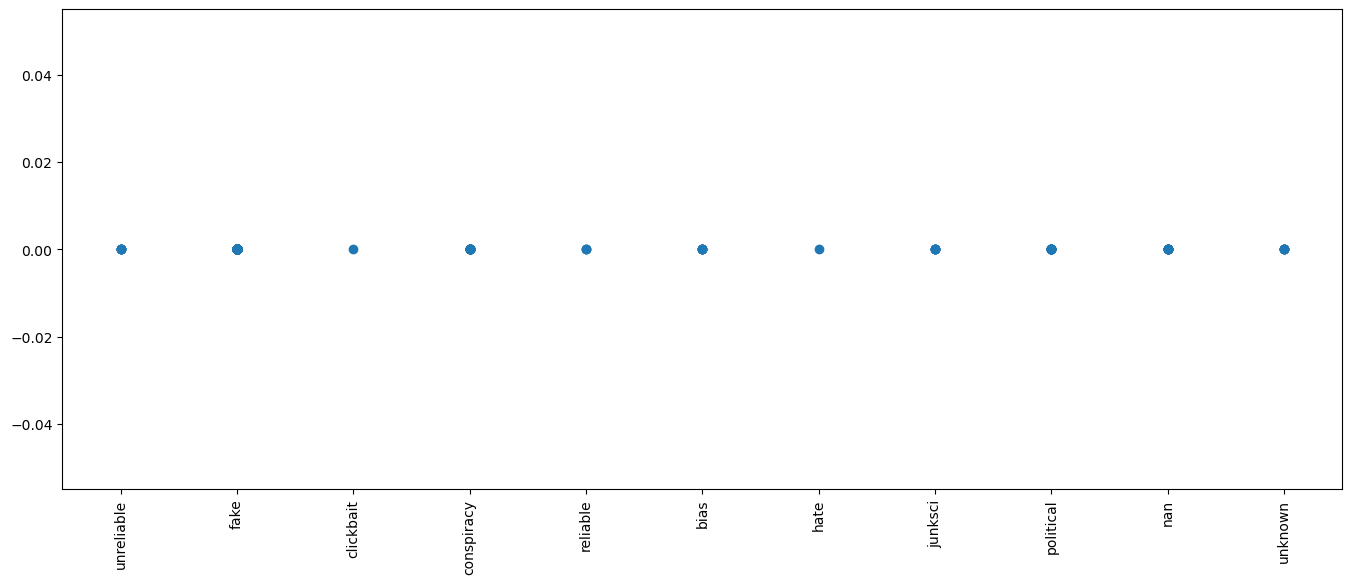

In [46]:
scatterplot_keyword_type('num')

In [47]:
def boxplot_keyword_type(keyword):
    tuple_array=pair_keyword_type(keyword) 
    boxdata=[]
    dict = {}
    for i in range(0,len(tuple_array)):
        if tuple_array[i][1] not in dict:
            dict[tuple_array[i][1]] = [tuple_array[i][0]]
        else:
            dict[tuple_array[i][1]].append(tuple_array[i][0])
    for i in dict:
        boxdata.append(dict[i])
    fig = plt.figure()
    ax =fig.add_axes([0,0,2,1])
    ax.boxplot(boxdata, labels = list(dict.keys()))
    plt.xticks(rotation = 'vertical')
    plt.show()

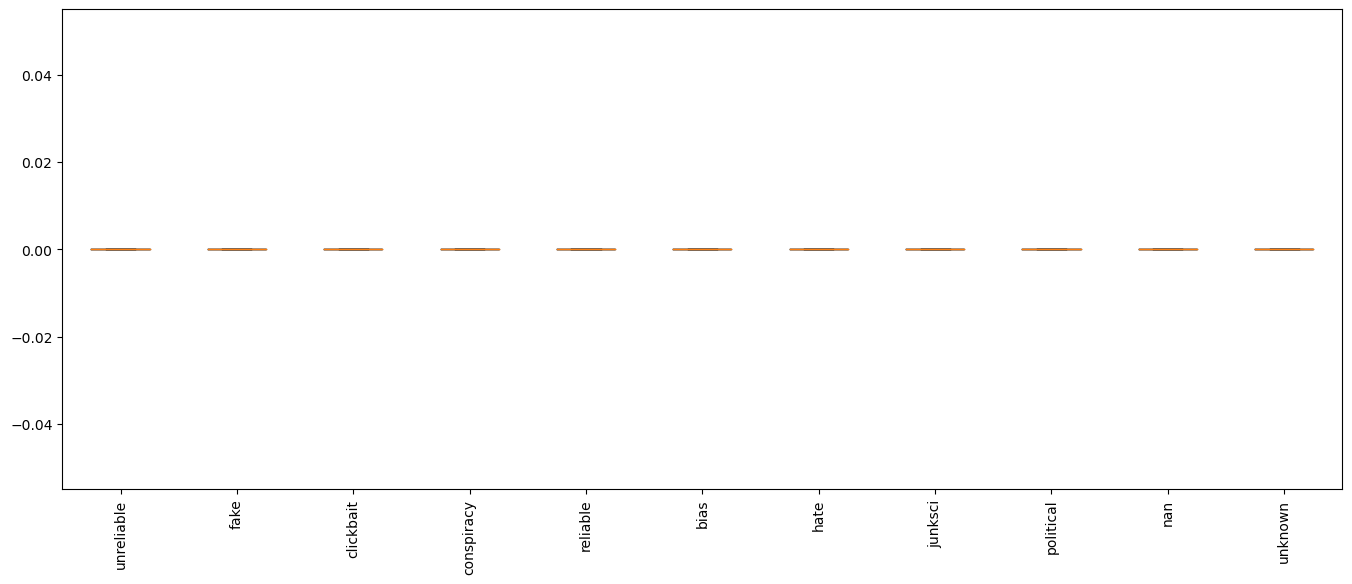

In [48]:
boxplot_keyword_type('trump')

In [49]:
def barplot_keyword_type(keyword): 
    tuple_array = pair_keyword_type(keyword)
    rawdict = {}
    for i in range(0,len(tuple_array)):
        if tuple_array[i][1] not in rawdict:
            rawdict[tuple_array[i][1]] = [tuple_array[i][0]]
        else:
            rawdict[tuple_array[i][1]].append(tuple_array[i][0])

    meandict={}
    for i in rawdict: 
        meandict[i] = np.mean(rawdict[i])
    mediandict={}
    for i in rawdict: 
        mediandict[i] = np.median(rawdict[i])
    meanvals =[]
    medianvals=[]
    for i in mediandict:
        medianvals.append(mediandict[i])
    for i in meandict:
        meanvals.append(meandict[i])
    types = list(mediandict.keys())
    types = [str(i) for i in types]
    print(medianvals)
    print(meanvals)
    print(types)
    df = pd.DataFrame({
    'types': types,
    'meanvals': meanvals,
    'medianvals': medianvals
    })
    df.plot(x="types", y=["meanvals", "medianvals"], kind="bar", figsize=(10,5))
    

[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
['unreliable', 'fake', 'clickbait', 'conspiracy', 'reliable', 'bias', 'hate', 'junksci', 'political', 'nan', 'unknown']


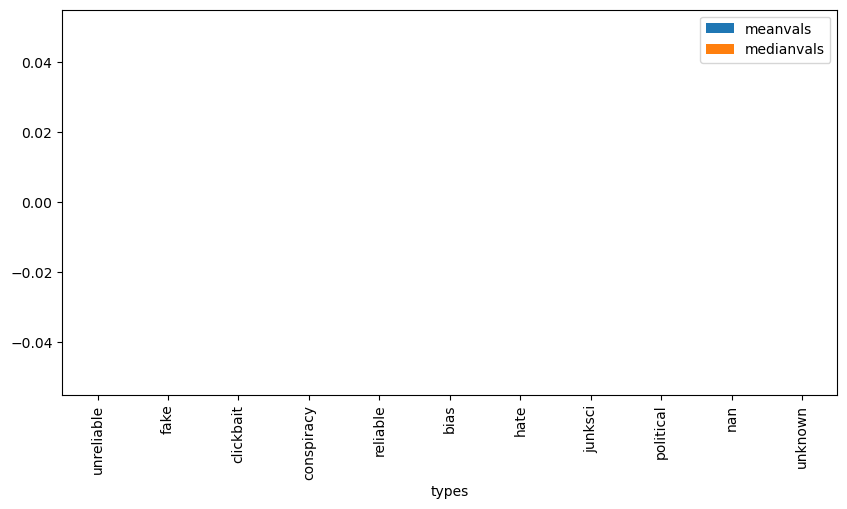

In [50]:
barplot_keyword_type('num') 

# Converting full data set to hdf5

First we import the necessary libraries

In [51]:
import csv
import pandas as pd
import h5py
import random
import pyarrow.feather as feather

We load the full data set

In [52]:
full_data = pd.read_csv("data/news_cleaned_2018_02_13-1.csv", on_bad_lines='skip')

KeyboardInterrupt: 

In [ ]:
len(full_data)

11558723

In [ ]:
full_data_sample = full_data.drop(full_data[(full_data['type'] != "fake") or (full_data['type'] != "reliable")]).sample(frac=0.1, random_state=1)

ValueError: The truth value of a Series is ambiguous. Use a.empty, a.bool(), a.item(), a.any() or a.all().

In [ ]:
full_data_sample.head()

,Unnamed: 0,id,domain,type,url,content,scraped_at,inserted_at,updated_at,title,authors,keywords,meta_keywords,meta_description,tags,summary,source
11467794,8027,9787368,nytimes.com,reliable,https://query.nytimes.com/gst/fullpage.html?re...,"KASHA--Audrey Sission, a lifelong New Yorker, ...",2018-02-11 00:48:58.787555,2018-02-11 00:14:20.346838,2018-02-11 00:14:20.346871,"Paid Notice: Deaths KASHA, AUDREY SISSION",NaN,NaN,['KASHA AUDREY SISSION'],"KASHA--Audrey Sission, a lifelong New Yorker, ...",NaN,NaN,nytimes
4591569,8760,3009581,thinkprogress.org,political,https://thinkprogress.org/into-the-valley-of-d...,"“Forward, the Light Brigade!”Was there a man d...",2017-11-18T20:01:27.400599,2018-02-07 23:39:33.852671,2018-02-07 23:39:33.852696,"Into The Valley Of Death Rode The 600, Into Th...",NaN,NaN,[''],NaN,"#Climate Change, #Climate",NaN,NaN
6162754,2521,4251195,truthandaction.org,bias,http://www.truthandaction.org/woman-thrown-off...,Woman Thrown Off Plane When She Said Hillary i...,2017-11-27T01:15:32.269834,2018-02-07 23:39:33.852671,2018-02-07 23:39:33.852696,Woman Thrown Off Plane When She Said Hillary i...,NaN,NaN,[''],NaN,NaN,NaN,NaN
4250359,effort to turn this election into a referendu...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4742331,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
len(full_data_sample)

1155872

In [ ]:
import gc

In [ ]:
del full_data
gc.collect()

15

In [ ]:
full_data_sample.head()

,Unnamed: 0,id,domain,type,url,content,scraped_at,inserted_at,updated_at,title,authors,keywords,meta_keywords,meta_description,tags,summary,source
11467794,8027,9787368,nytimes.com,reliable,https://query.nytimes.com/gst/fullpage.html?re...,"KASHA--Audrey Sission, a lifelong New Yorker, ...",2018-02-11 00:48:58.787555,2018-02-11 00:14:20.346838,2018-02-11 00:14:20.346871,"Paid Notice: Deaths KASHA, AUDREY SISSION",NaN,NaN,['KASHA AUDREY SISSION'],"KASHA--Audrey Sission, a lifelong New Yorker, ...",NaN,NaN,nytimes
4591569,8760,3009581,thinkprogress.org,political,https://thinkprogress.org/into-the-valley-of-d...,"“Forward, the Light Brigade!”Was there a man d...",2017-11-18T20:01:27.400599,2018-02-07 23:39:33.852671,2018-02-07 23:39:33.852696,"Into The Valley Of Death Rode The 600, Into Th...",NaN,NaN,[''],NaN,"#Climate Change, #Climate",NaN,NaN
6162754,2521,4251195,truthandaction.org,bias,http://www.truthandaction.org/woman-thrown-off...,Woman Thrown Off Plane When She Said Hillary i...,2017-11-27T01:15:32.269834,2018-02-07 23:39:33.852671,2018-02-07 23:39:33.852696,Woman Thrown Off Plane When She Said Hillary i...,NaN,NaN,[''],NaN,NaN,NaN,NaN
4250359,effort to turn this election into a referendu...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4742331,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
full_data_sample.tail()

,Unnamed: 0,id,domain,type,url,content,scraped_at,inserted_at,updated_at,title,authors,keywords,meta_keywords,meta_description,tags,summary,source
880814,6934,690264,ecowatch.com,political,https://www.ecowatch.com/rooftop-solar-provide...,Cowry Collective members participate in a time...,2018-01-25 20:13:50.426130,2018-02-02 01:19:41.756632,2018-02-02 01:19:41.756664,Rooftop Solar Provides Net Benefits to All Nev...,"Natural Resources Defense Council, Yes, The Co...",NaN,"['energy', 'renewables', 'featured']",The Natural Resources Defense Council (NRDC) a...,NaN,NaN,NaN
11467044,7277,9786618,nytimes.com,reliable,https://www.nytimes.com/2016/06/13/sports/hock...,"Murray, who is 22, added: “I probably won’t be...",2018-02-11 00:48:58.399133,2018-02-11 00:14:20.346838,2018-02-11 00:14:20.346871,Penguins Finish Off Sharks to Win Stanley Cup,David Pollak,NaN,"['Hockey Ice', 'Stanley Cup', 'Playoff Games'...",Pittsburgh won its second Stanley Cup in eight...,NaN,NaN,nytimes
6698083,"put all doubts to rest by mobilizing the…""",2017-11-27T01:15:17.147615,2018-02-07 23:39:33.852671,2018-02-07 23:39:33.852696,Hillary Clinton and the Politics of Overcompen...,NaN,NaN,[''],Likely Democratic party presidential candidate...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6510986,753,4640342,express.co.uk,rumor,https://www.express.co.uk/showbiz/tv-radio/726...,"The 69-year-old actor, and former EastEnders s...",2017-11-27T01:14:33.570665,2018-02-07 23:39:33.852671,2018-02-07 23:39:33.852696,I’m A Celebrity 2016: Is Larry Lamb joining th...,Rory O'Connor,NaN,[''],LARRY LAMB is the latest celebrity to have agr...,NaN,NaN,NaN
6794053,459,4934743,dailykos.com,political,https://www.dailykos.com/news/SameSexBinationa...,Leandra English files suit seeking restraining...,2017-11-27T01:14:21.395055,2018-02-07 23:39:33.852671,2018-02-07 23:39:33.852696,Daily Kos: SameSexBinationalCouples,"Happy Cog Studios - Http, Www.Happycog.Com, Da...",NaN,[''],NaN,Next,NaN,NaN


In [ ]:
full_data_sample.to_csv("data/sample.csv")

remove all rows where the "content" tab is null

In [ ]:
full_data_sample_clean_content = full_data_sample.drop(full_data_sample[full_data_sample.content.isnull()].index)

In [ ]:
full_data_sample_clean_content.head()

,Unnamed: 0,id,domain,type,url,content,scraped_at,inserted_at,updated_at,title,authors,keywords,meta_keywords,meta_description,tags,summary,source
11467794,8027,9787368,nytimes.com,reliable,https://query.nytimes.com/gst/fullpage.html?re...,"KASHA--Audrey Sission, a lifelong New Yorker, ...",2018-02-11 00:48:58.787555,2018-02-11 00:14:20.346838,2018-02-11 00:14:20.346871,"Paid Notice: Deaths KASHA, AUDREY SISSION",NaN,NaN,['KASHA AUDREY SISSION'],"KASHA--Audrey Sission, a lifelong New Yorker, ...",NaN,NaN,nytimes
4591569,8760,3009581,thinkprogress.org,political,https://thinkprogress.org/into-the-valley-of-d...,"“Forward, the Light Brigade!”Was there a man d...",2017-11-18T20:01:27.400599,2018-02-07 23:39:33.852671,2018-02-07 23:39:33.852696,"Into The Valley Of Death Rode The 600, Into Th...",NaN,NaN,[''],NaN,"#Climate Change, #Climate",NaN,NaN
6162754,2521,4251195,truthandaction.org,bias,http://www.truthandaction.org/woman-thrown-off...,Woman Thrown Off Plane When She Said Hillary i...,2017-11-27T01:15:32.269834,2018-02-07 23:39:33.852671,2018-02-07 23:39:33.852696,Woman Thrown Off Plane When She Said Hillary i...,NaN,NaN,[''],NaN,NaN,NaN,NaN
2542246,2019,1769246,ecowatch.com,political,https://www.ecowatch.com/cuban-province-well-o...,Cuban Province Well on Its Way to 100% Renewab...,2017-11-10T11:18:44.524042,2018-02-07 23:39:33.852671,2018-02-07 23:39:33.852696,Cuban Province Well on Its Way to 100% Renewab...,"Guest Contributor, Sierra Club, Common Dreams,...",NaN,"['featured', 'renewables', 'business', 'cuba']",President Obama’s recent announcement that he ...,NaN,NaN,NaN
3753783,4806,2429386,weeklystandard.com,political,http://www.weeklystandard.com/print/the-times-...,\n\n\n\nThe New York Times greeted delegates w...,2017-11-13T18:09:27.760857,2018-02-07 23:39:33.852671,2018-02-07 23:39:33.852696,The Times Repeats Itself,To The Scrapbook,NaN,['The Scrapbook'],The New York Times greeted delegates with a fr...,NaN,NaN,NaN


In [ ]:
print("Removed " + str(len(full_data_sample) - len(full_data_sample_clean_content)) + " rows")

Removed 210005 rows


In [ ]:
full_data_sample_clean_content = full_data_sample_clean_content[pd.to_numeric(full_data_sample_clean_content['Unnamed: 0'], errors='coerce').notnull()]

In [ ]:
len(full_data_sample_clean_content)

929381

In [ ]:
full_data_sample_clean_content['Unnamed: 0'] = full_data_sample_clean_content['Unnamed: 0'].astype('int64')

/var/folders/gj/r8x5s5mn7jg12hs3c28wpg4c0000gn/T/ipykernel_1600/3315519236.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  full_data_sample_clean_content['Unnamed: 0'] = full_data_sample_clean_content['Unnamed: 0'].astype('int64')


In [ ]:
full_data_sample_clean_content['id'] = full_data_sample_clean_content['id'].astype('int64')

/var/folders/gj/r8x5s5mn7jg12hs3c28wpg4c0000gn/T/ipykernel_1600/3811944661.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  full_data_sample_clean_content['id'] = full_data_sample_clean_content['id'].astype('int64')


In [ ]:
len(full_data_sample_clean_content)

929381

In [ ]:
full_data_sample_clean_content.dtypes

Unnamed: 0           int64
id                   int64
domain              object
type                object
url                 object
content             object
scraped_at          object
inserted_at         object
updated_at          object
title               object
authors             object
keywords            object
meta_keywords       object
meta_description    object
tags                object
summary             object
source              object
dtype: object

In [ ]:
import pyarrow.parquet as pq
import pyarrow as pa

In [ ]:
sample_parquet = pa.Table.from_pandas(full_data_sample_clean_content)

In [ ]:
pq.write_table(sample_parquet, "data/sample_STRUCTURED.parquet")

In [ ]:
sample = feather.read_feather("data/sample_feather")

In [ ]:
len(sample)

929381

In [ ]:
full_data_sample_clean_content.tail()

,Unnamed: 0,id,domain,type,url,content,scraped_at,inserted_at,updated_at,title,authors,keywords,meta_keywords,meta_description,tags,summary,source
1658197,7865,849316,dailykos.com,political,https://www.dailykos.com/stories/2017/01/25/16...,U.S. naval base at Guantánamo Bay\n\nWhite Hou...,2018-01-25 20:13:50.426130,2018-02-02 01:19:41.756632,2018-02-02 01:19:41.756664,Spokesman denies reports that Trump regime pla...,"Backgroundurl Avatar_Large, Nickname, Joined, ...",NaN,[''],NaN,NaN,NaN,NaN
880814,6934,690264,ecowatch.com,political,https://www.ecowatch.com/rooftop-solar-provide...,Cowry Collective members participate in a time...,2018-01-25 20:13:50.426130,2018-02-02 01:19:41.756632,2018-02-02 01:19:41.756664,Rooftop Solar Provides Net Benefits to All Nev...,"Natural Resources Defense Council, Yes, The Co...",NaN,"['energy', 'renewables', 'featured']",The Natural Resources Defense Council (NRDC) a...,NaN,NaN,NaN
11467044,7277,9786618,nytimes.com,reliable,https://www.nytimes.com/2016/06/13/sports/hock...,"Murray, who is 22, added: “I probably won’t be...",2018-02-11 00:48:58.399133,2018-02-11 00:14:20.346838,2018-02-11 00:14:20.346871,Penguins Finish Off Sharks to Win Stanley Cup,David Pollak,NaN,"['Hockey Ice', 'Stanley Cup', 'Playoff Games'...",Pittsburgh won its second Stanley Cup in eight...,NaN,NaN,nytimes
6510986,753,4640342,express.co.uk,rumor,https://www.express.co.uk/showbiz/tv-radio/726...,"The 69-year-old actor, and former EastEnders s...",2017-11-27T01:14:33.570665,2018-02-07 23:39:33.852671,2018-02-07 23:39:33.852696,I’m A Celebrity 2016: Is Larry Lamb joining th...,Rory O'Connor,NaN,[''],LARRY LAMB is the latest celebrity to have agr...,NaN,NaN,NaN
6794053,459,4934743,dailykos.com,political,https://www.dailykos.com/news/SameSexBinationa...,Leandra English files suit seeking restraining...,2017-11-27T01:14:21.395055,2018-02-07 23:39:33.852671,2018-02-07 23:39:33.852696,Daily Kos: SameSexBinationalCouples,"Happy Cog Studios - Http, Www.Happycog.Com, Da...",NaN,[''],NaN,Next,NaN,NaN


In [ ]:
feather.write_feather(full_data_sample_clean_content, "data/sample_feather")

In [ ]:
with open("data/data_preprocessed.csv", "r") as inp, open("data/data_preprocessed_STRUCTURED.csv", "w") as out:
    writer = csv.writer(out)
    for row in csv.reader(inp):
        if (len(row) != 17) or (not (row[1].isnumeric())) or (row[6] == [] or (row[3])):
            continue
        else:
            writer.writerow(row)

new entry
False
False
False
new entry
False
True
False
new entry
False
True
False
new entry
False
True
False
new entry
False
True
False
new entry
False
True
False
new entry
False
True
False
new entry
False
True
False
new entry
False
True
False
new entry
False
True
False
new entry
False
True
False
new entry
False
True
False
new entry
False
True
False
new entry
False
True
False
new entry
False
True
False
new entry
False
True
False
new entry
False
True
False
new entry
False
True
False
new entry
False
True
False
new entry
False
True
False
new entry
False
True
False
new entry
False
True
False
new entry
False
True
False
new entry
False
True
False
new entry
False
True
False
new entry
False
True
False
new entry
False
True
False
new entry
False
True
False
new entry
False
True
False
new entry
False
True
False
new entry
False
True
False
new entry
False
True
False
new entry
False
True
False
new entry
False
True
False
new entry
False
True
False
new entry
False
True
False
new entry
False
True
False


In [ ]:
import csv 
import sys
csv.field_size_limit(sys.maxsize)
skipped_rows = 0

def isvalidrow(row):
    if (len(row) != 17) or (not (row[1].isnumeric())) or (not (row[0].isnumeric())) or (row[6] == "") or (type(row[4]) is not str):
        return False
    else:
        return True

with open("data/news_cleaned_2018_02_13-1.csv", "r") as inp, open("data/news_cleaned_2018_02_13-1_STRUCTURED.csv", "w") as out:
    writer = csv.writer(out)
    reader = csv.reader(inp)
    column_names = next(reader)
    writer.writerow(column_names)
    for row in reader:
        if (not isvalidrow(row)):
            skipped_rows += 1
            continue
        else:
            writer.writerow(row)
print("skipped " + str(skipped_rows) + " rows")

skipped 349 rows


In [ ]:
full_data = pd.read_csv("data/news_cleaned_2018_02_13-1_STRUCTURED.csv", chunksize=10000)

In [ ]:
full_data_sample = full_data.sample(frac=0.1, random_state=1)

In [ ]:
full_data_sample.to_parquet("data/full_data_sample")

: 

: 

In [ ]:
dtypes = {
    "Unnamed: 0 " : 'int64',
    "id" : 'str',
    "domain" : 'str',
    "type" : 'str',
    "url" : 'str',
    "content" : 'str',
    "scaped_at" : 'str',
    "inserted_at" : 'str',
    "updated_at" : 'str',
    "title" : 'str',
    "authors" : 'str',
    "keywords" : 'float64',
    "meta_keywords" : 'str',
    "tags" : 'str',
    "summary" : 'str',
}

In [ ]:
#full_data = pd.read_csv("data/news_cleaned_2018_02_13-1.csv", on_bad_lines='skip', dtype=data.dtypes.to_dict())

ValueError: invalid literal for int() with base 10: 'It appears that the severing between the divisive\xa0biotech company and the pediatricians association w...'

In [ ]:
import numpy as np
testdf = pd.DataFrame(np.arange(10).reshape(5,2), columns=['x', 'y'])
print(testdf)

In [ ]:
with open("data/test.csv", "r") as file:
    for row in file:
        df = pd.DataFrame([row.split(",")], columns=["name", "age", "height"])
        print(df)

In [ ]:
""" from IPython.display import display
from ipywidgets import IntProgress
import csv
rows = 216215374
column_names = []
with open("data/news_cleaned_2018_02_13-1.csv", "r") as file:
    for row in file:
        column_names = row.split(",")
        break
with open("data/news_cleaned_2018_02_13-1.csv", "r") as file:
    progress_bar = IntProgress(min=0, max=rows)
    display(progress_bar)
    reader = csv.reader(file)
    next(reader, None)
    for row in reader:
        store = pd.HDFStore("data/news_cleaned_2018_02_13-1.h5")
        df = pd.DataFrame([row], columns=column_names)
        store.append('data', df)
        store.close()
        progress_bar.value += 1 """

In [ ]:
""" for i in range (3):
    df = pd.DataFrame(np.arange(10).reshape(5,2)*10**i, columns=['x','y'])
    store.append('data', df)

store.close()
store = pd.HDFStore(filename)
data = store['data']
print(data)
store.close() """

In [ ]:
import csv
import pandas as pd
import h5py
import random
import pyarrow.feather as feather

In [ ]:
read_feather_raw_data = feather.read_feather("data/raw_data")

In [ ]:
#full_data = pd.read_csv("data/news_cleaned_2018_02_13-1.csv", on_bad_lines='skip',dtype=)

In [ ]:
#feather.write_feather(full_data, "data/full_data")

In [ ]:
random_row_indicies = [0]
random_row_indicies = random_row_indicies + random.sample(range(1,9000000), 10000)
random_row_indicies.sort()
random_row_indicies


In [ ]:
#df = pd.read_csv("data/news_cleaned_2018_02_13-1.csv", skiprows= lambda x: x not in random_row_indicies)

In [ ]:
# TEST PREPROCESSING SPEED
for chunck in pd.read_csv("data/news_cleaned_2018_02_13-1.csv", chunksize=10000):
    print("cleaning...")
    clean_dataframe(chunck)
    print("preprocessing...")
    preprocess(chunck)
    chunck.to_csv("data/news_preprocessed.csv")
    break

cleaning...
preprocessing...
Tokenizing...
Removing stopwords...
Reduction rate of removing stopwords: 0.0
Stemming...


TypeError: 'function' object is not iterable

In [ ]:
#full_data.to_hdf("data.hf", key="full_data", mode="w")

In [ ]:
""" hf = h5py.File("data/news_cleaned_2018_02_13.h5", 'w')
hf.create_dataset('dataset', data=full_data)
hf.close() """
#filename = "data/news_cleaned_2018_02_13.h5"
""" for chunk in pd.read_csv("data/news_cleaned_2018_02_13-1.csv", chunksize=1):
    print("opening file...")
    chunk.to_hdf(filename, 'data', mode='w', format='table')
    print(chunk.columns)
    break
for chunk in pd.read_csv("data/news_cleaned_2018_02_13-1.csv", chunksize=1000):
    print(chunk.columns)
    clean(chunk)
    preprocess(chunk)
    chunk.to_hdf(filename, 'data', data_columns=chunk.columns, append=True) """
""" for chunk in pd.read_csv("data/news_cleaned_2018_02_13-1.csv", chunksize=1000):
    store.append('data', chunk, data_columns=chunk.columns, min_itemsize={'content': 48577, 'title': 208})
store.close() """

In [ ]:
y = df['type']

In [ ]:
len(df)

In [ ]:
# full_data.to_hdf("data/news_cleaned_2018_02_13.h5", key='df', mode='w')